# Analysis of GWL projections

In [1]:
#import libraries
%matplotlib notebook
import geopandas as gpd
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os
from functions import setinputdataset
#from statsmodels.tsa.seasonal import seasonal_decompose
#from scipy.stats import linregress
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors
import contextily as cx
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from functions import mapplots, mapplots2, mapplotsproj
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pymannkendall as mk
from matplotlib.colors import LinearSegmentedColormap
import importlib

In [2]:
patht="D:/Erasmus/Thesis/"
pathdat=patht+"/data/"

pathshp=pathdat+"/SHP/SHP2/"
pathrast=pathdat+"/Raster/"
pathpick=pathdat+"/Pickle/"
pathfig=patht+"/Figures/"

path=r"D:\Erasmus\Thesis\Code\08072022\GW_forecasting_ML\projections/"

In [18]:
#list of wells with NSE>0.5 and r2>0.6
well_list = pd.read_csv(path+"/well_list60.txt")

#Name of climate model projections available (given by the DWD)
Proj_names=["MPI_WRF361H", "MPI_CCLM", "MIROC_CCLM", 
         "HadGEM_WRF361H", "ECE_RACMO_r12", "ECE_RACMO_r1"]
#Import spatial information per well -- results of the Accuracy_plot script
gw_sel_int=gpd.read_file(pathshp+"gw_sel_intmod2.shp")

In [19]:
#Check what happened with these wells
gw_sel_proj=gw_sel_int.loc[gw_sel_int.MEST_ID.isin(well_list.MEST_ID)]

In [20]:
#Filter optimized models r2>0.7 and NSE > 0.6
gw_sel_proj=gw_sel_proj.loc[(gw_sel_proj['r2_2']>0.7)&(gw_sel_proj['NSE_2']>0.6)].reset_index()

In [ ]:
#Administrative boundaries
germany_states = gpd.read_file(pathshp+"DEU_adm1.shp")
ND=germany_states[germany_states.NAME_1== "Niedersachsen"]
waterbodies=gpd.read_file(pathshp+"waterbodiesND.shp")
waterways=gpd.read_file(pathshp+"waterwaysND.shp")
citiesND=gpd.read_file(pathshp+"citiesND2.shp")

#project coordinate sytem
proj_coor=4647
gw_sel_proj=gw_sel_proj.to_crs(epsg=proj_coor)
waterbodies=waterbodies.to_crs(epsg=proj_coor)
waterways=waterways.to_crs(epsg=proj_coor)
bound=germany_states.to_crs(gw_sel_proj.crs.to_string()) 
ND=ND.to_crs(epsg=proj_coor)
cities=citiesND.to_crs(epsg=proj_coor)

<IPython.core.display.Javascript object>


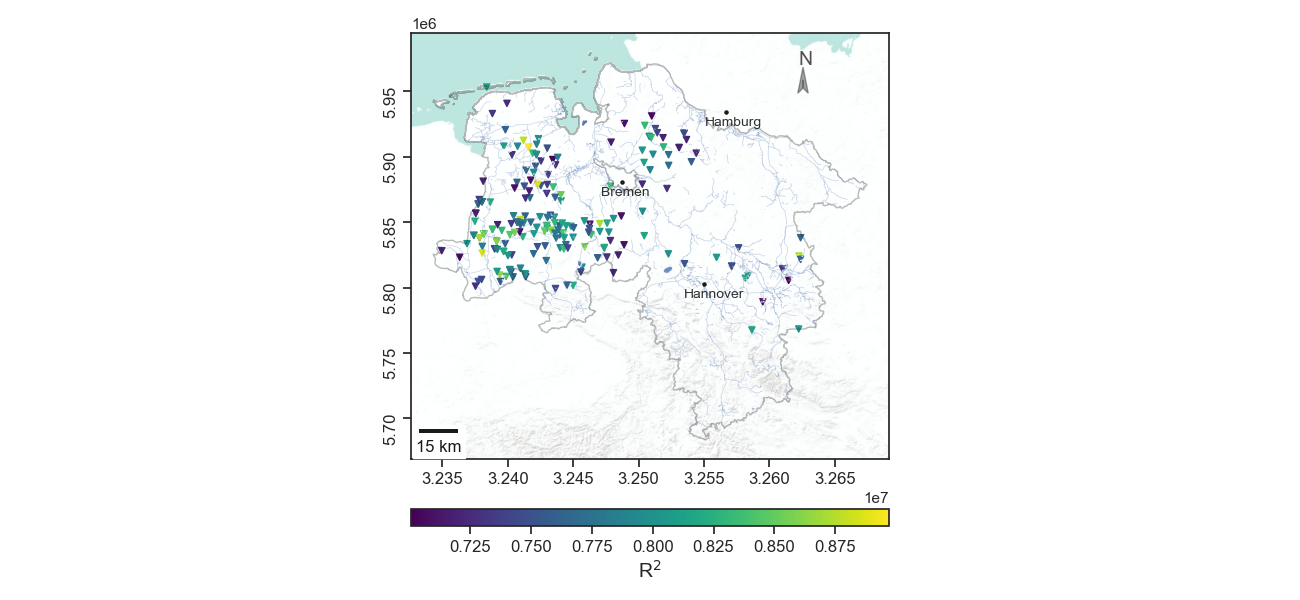

In [22]:
cmap="viridis"

fig, gw = plt.subplots(ncols=1, figsize=(13, 6))
gw=mapplots2(column='r2_2',cmap=cmap,bound=bound,axs=gw,gw_s=gw_sel_proj,
            waterbodies=waterbodies,waterways=waterways,cities=cities,ND=ND,normalize=True)

#gw2=mapplots(column='FOK',cmap=cmap,bound=bound,axs=gw2)
plt.tight_layout()    
#plt.savefig(pathfig+"PT.pdf")

## Load GWL projections

In [23]:
ct=0
gw_sel_projr=gw_sel_proj.reset_index()
well_list=well_list.reset_index()

for pjname in Proj_names:
    gw_sel_projr[pjname+'_scores']=np.zeros(len(gw_sel_projr))
    prdfs=[]
    ldwell=[]
    for wellid in well_list.MEST_ID:
        ct+=1
        projgwl=pd.read_csv(path+'/'+str(wellid)+'/'+'ensemble_mean_values_CNN_'
                            +str(wellid)+'_'+pjname+'.txt', sep=';')
        projgwl.index=pd.to_datetime(projgwl['dates'])
        scores=pd.read_csv(path+'/'+str(wellid)+'/'+pjname+'_scores.txt', sep=',')
        
        iwell=gw_sel_projr.loc[gw_sel_projr.MEST_ID==wellid].index
        
        if not iwell.empty:
            # select only R2 to check the projections
            gw_sel_projr.at[iwell[0],pjname+'_scores']=round(scores.R2.values[0],3) 
            prdfs.append(projgwl)
            ldwell.append(iwell[0])
    
    df=pd.DataFrame({'wellids':ldwell, pjname+'_proj': prdfs})
    gw_sel_projr[pjname+'_proj']=df[pjname+'_proj'].copy()        
    

In [103]:
#gw_sel_projr.to_pickle(pathpick+"/gw_sel_projr.pkl")

## Plot correlation between GWL observations and projections

<IPython.core.display.Javascript object>


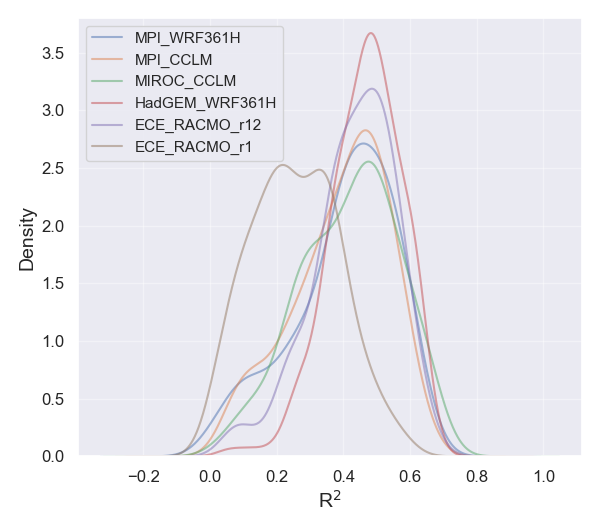

In [10]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(6,5.3))
for pjname in Proj_names:
    gw_sel_projr[pjname+'_scores'].plot.kde(label=pjname,alpha=0.5)
plt.ylim([0,3.8])
plt.xlabel('R$^2$', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(True, alpha=0.4)
plt.tick_params(  labelsize=12)
plt.legend()
plt.tight_layout()
plt.savefig(pathfig+"histprojscore.pdf",bbox_inches="tight",dpi=300)

In [ ]:
fig, gw = plt.subplots(nrows=2,ncols=1, sharex=False, figsize=(13, 16))
gw[0,0]=mapplots(column='HadGEM_WRF361H_scores',cmap='viridis',bound=bound,axs=gw[0,0],gw_s=gw_sel_proj,
            waterbodies=waterbodies,waterways=waterways,ND=ND)
gw[0,1]=mapplots(column='ECE_RACMO_r12_scores',cmap='viridis',bound=bound,axs=gw[0,1],gw_s=gw_sel_proj,
            waterbodies=waterbodies,waterways=waterways,ND=ND)
#gw[1,0]=mapplots(column='MPI_CCLM_scores',cmap='viridis',bound=bound,axs=gw[1,0],gw_s=gw_sel_proj,
#            waterbodies=waterbodies,waterways=waterways,ND=ND)
#gw[1,1]=mapplots(column='MPI_WRF361H_scores',cmap='viridis',bound=bound,axs=gw[1,1],gw_s=gw_sel_proj,
#            waterbodies=waterbodies,waterways=waterways,ND=ND)

#gw2=mapplots(column='FOK',cmap=cmap,bound=bound,axs=gw2)
plt.tight_layout()    
#plt.savefig(pathfig+"PT.pdf")

<IPython.core.display.Javascript object>


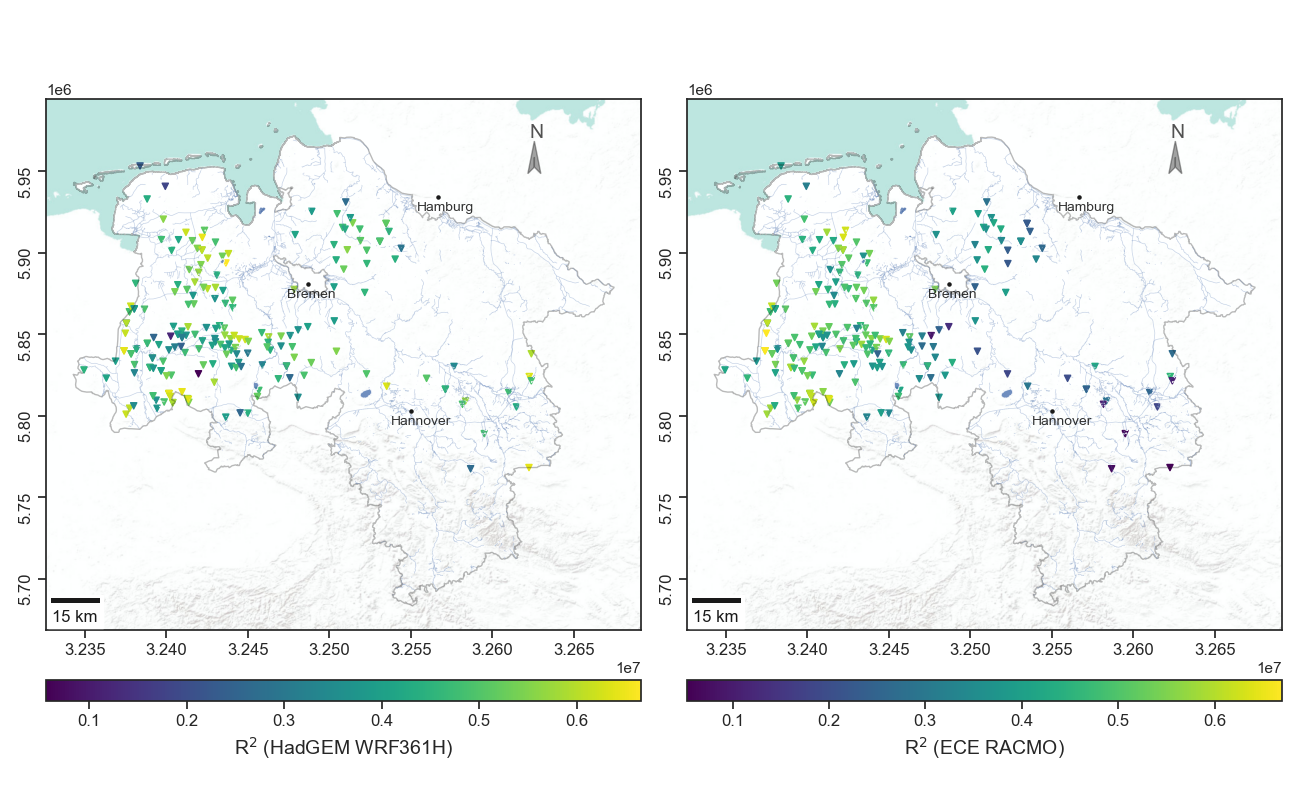

In [11]:
sns.set_theme(style="ticks")
pathfig=r"D:/Erasmus/Thesis/Figures/"
fig, (gw,gw2) = plt.subplots(nrows=1,ncols=2, sharex=False, figsize=(13, 8))
gw=mapplots2(column='HadGEM_WRF361H_scores',cmap='viridis',bound=bound,axs=gw,gw_s=gw_sel_projr,
            waterbodies=waterbodies,waterways=waterways,cities=cities,ND=ND,normalize=True)

            
gw2=mapplots2(column='ECE_RACMO_r12_scores',cmap='viridis',bound=bound,axs=gw2,gw_s=gw_sel_projr,
            waterbodies=waterbodies,waterways=waterways,cities=cities,ND=ND,normalize=True)


#gw2=mapplots(column='FOK',cmap=cmap,bound=bound,axs=gw2)
plt.tight_layout()    
plt.savefig(pathfig+"PT_scores.jpg",bbox_inches="tight",dpi=200)

## Trend

__Mann-Kendall test__ -- for seasonal time series\
-_trend_: tells the trend (increasing, decreasing or no trend)\
-_h_: True (if trend is present) or False (if the trend is absence)\
-_p_: p-value of the significance test\
-_z_: normalized test statistics\
-_Tau_: Kendall Tau\
-_s_: Mann-Kendal's score\
-_var_s_: Variance S\
-_slope_: Theil-Sen estimator/slope\
-_intercept_: intercept of Kendall-Theil Robust Line, for seasonal test, full period cycle consider as unit time step

Hussain et al., (2019). pyMannKendall: a python package for non parametric Mann Kendall family of trend tests.. Journal of Open Source Software, 4(39), 1556, https://doi.org/10.21105/joss.01556

In [24]:
datei=pd.to_datetime('01012020', format='%d%m%Y')
datem=pd.to_datetime('01012050', format='%d%m%Y')
datem2=pd.to_datetime('01012060', format='%d%m%Y')
datef=pd.to_datetime('01012090', format='%d%m%Y')
datef2=gw_sel_projr[pjname+'_proj'][0].Sim.index[-1]

In [25]:
deltmonthsnf=(datem.year-datei.year)*3
deltmonthsff=(datef.year-datem2.year)*3
dmonths=(datef2.year-datei.year)*3

In [26]:
period=12
alpha=0.05
seasonsv=['winter','summer']
for season in seasonsv:
    for pjname in Proj_names:

        gw_sel_projr[pjname+'_'+season+'_slopenf']=np.zeros(len(gw_sel_projr))
        gw_sel_projr[pjname+'_'+season+'_trendnf']=np.zeros(len(gw_sel_projr))
        gw_sel_projr[pjname+'_'+season+'_pvalnf']=np.zeros(len(gw_sel_projr))
        gw_sel_projr[pjname+'_'+season+'_deltanf']=np.zeros(len(gw_sel_projr)) 
        gw_sel_projr[pjname+'_'+season+'_slopeff']=np.zeros(len(gw_sel_projr))
        gw_sel_projr[pjname+'_'+season+'_trendff']=np.zeros(len(gw_sel_projr))
        gw_sel_projr[pjname+'_'+season+'_pvalff']=np.zeros(len(gw_sel_projr)) 
        gw_sel_projr[pjname+'_'+season+'_deltaff']=np.zeros(len(gw_sel_projr)) 
        gw_sel_projr[pjname+'_'+season+'_slope']=np.zeros(len(gw_sel_projr))
        gw_sel_projr[pjname+'_'+season+'_trend']=np.zeros(len(gw_sel_projr))
        gw_sel_projr[pjname+'_'+season+'_pval']=np.zeros(len(gw_sel_projr)) 
        gw_sel_projr[pjname+'_'+season+'_delta']=np.zeros(len(gw_sel_projr)) 


        for i in range(len(gw_sel_projr[pjname+'_proj'])):

            mw=int(gw_sel_projr[season+'proj'][i])
            if mw!= 1: 
                inx=np.where(gw_sel_projr[pjname+'_proj'][i].index.month.isin([mw-1,mw,mw+1]))[0]
            else:
                inx=np.where(gw_sel_projr[pjname+'_proj'][i].index.month.isin([12,mw,mw+1]))[0]

            dfproj=gw_sel_projr[pjname+'_proj'][i].Sim[inx]

            nearfuture=dfproj.loc[(dfproj.index>datei)&
                                  (dfproj.index<datem)]
            farfuture=dfproj.loc[dfproj.index>datem2]

            future=dfproj.loc[dfproj.index>datei]

            overlap=dfproj.loc[(dfproj.index<datei)]
            overlapff=dfproj.loc[(dfproj.index>pd.to_datetime('01012045', format='%d%m%Y')) 
                                 & (dfproj.index<datem2)]


            #Seasonal Mann-Kendall test also developed to remove the effect of seasonality
            trendnf, hnf, pnf, znf, Taunf, snf, var_snf, slopenf, interceptnf =mk.yue_wang_modification_test(nearfuture)
            trendff, hff, pff, zff, Tauff, sff, var_sff, slopeff, interceptff =mk.yue_wang_modification_test(farfuture)
            trend, h, p, z, Tau, s, var_s, slope, intercept =mk.yue_wang_modification_test(future)

            gw_sel_projr.at[i,pjname+'_'+season+'_slopenf']=slopenf
            gw_sel_projr.at[i,pjname+'_'+season+'_trendnf']=trendnf
            gw_sel_projr.at[i,pjname+'_'+season+'_pvalnf']=pnf
            gw_sel_projr.at[i,pjname+'_'+season+'_deltanf']=(slopenf*deltmonthsnf)/np.abs(overlap.mean())*100

            gw_sel_projr.at[i,pjname+'_'+season+'_slopeff']=slopeff
            gw_sel_projr.at[i,pjname+'_'+season+'_trendff']=trendff
            gw_sel_projr.at[i,pjname+'_'+season+'_pvalff']=pff     
            gw_sel_projr.at[i,pjname+'_'+season+'_deltaff']=(slopeff*deltmonthsff)/np.abs(overlapff.mean())*100

            gw_sel_projr.at[i,pjname+'_'+season+'_slope']=slope
            gw_sel_projr.at[i,pjname+'_'+season+'_trend']=trend
            gw_sel_projr.at[i,pjname+'_'+season+'_pval']=p    
            gw_sel_projr.at[i,pjname+'_'+season+'_delta']=(slope*dmonths)/np.abs(overlap.mean())*100

        gw_sel_projr[pjname+'_'+season+'_deltanf2'] = [np.nan if y == 'no trend' else x for x,y in zip(gw_sel_projr[pjname+'_'+season+'_deltanf'],
                                                                                           gw_sel_projr[pjname+'_'+season+'_trendnf'] )]
        gw_sel_projr[pjname+'_'+season+'_deltaff2'] = [np.nan if y == 'no trend' else x for x,y in zip(gw_sel_projr[pjname+'_'+season+'_deltaff'],
                                                                                           gw_sel_projr[pjname+'_'+season+'_trendff'] )]
        gw_sel_projr[pjname+'_'+season+'_delta2'] = [np.nan if y == 'no trend' else x for x,y in zip(gw_sel_projr[pjname+'_'+season+'_delta'],
                                                                                           gw_sel_projr[pjname+'_'+season+'_trend'] )]

            #print(trendnf,trendff)

In [140]:
#Save dataframe to pickle
#gw_sel_projr.to_pickle(pathpick+'gw_sel_projseason.pkl') 

<IPython.core.display.Javascript object>


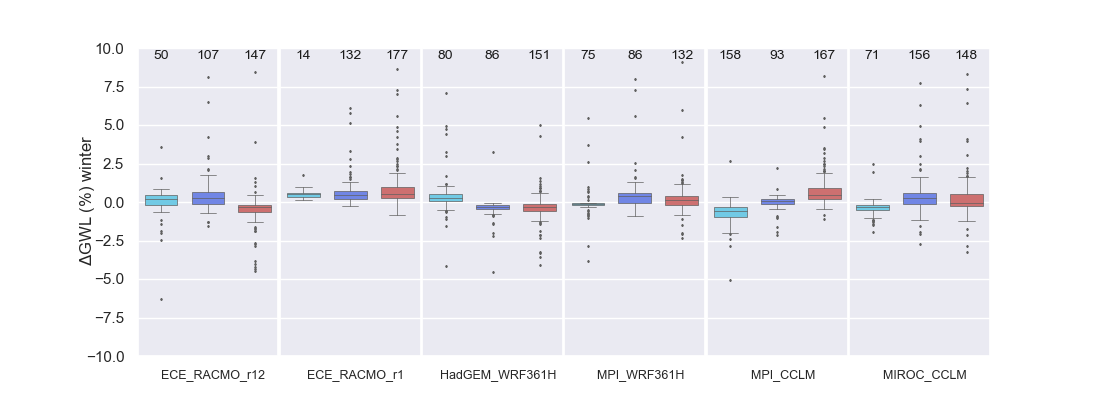

In [27]:
lnames=[' '*30+'ECE_RACMO_r12',' ',' ',
        ' '*30+'ECE_RACMO_r1',' ',' ',
        ' '*30+'HadGEM_WRF361H',' ',' ',
        ' '*30+'MPI_WRF361H', ' ',' ',
        ' '*30+'MPI_CCLM', ' ',' ',
        ' '*30+'MIROC_CCLM',  ' ',' ']
season='winter'

col=['ECE_RACMO_r12_'+season+'_deltanf2','ECE_RACMO_r12_'+season+'_deltaff2','ECE_RACMO_r12_'+season+'_delta2',
     'ECE_RACMO_r1_'+season+'_deltanf2','ECE_RACMO_r1_'+season+'_deltaff2','ECE_RACMO_r1_'+season+'_delta2',
     'HadGEM_WRF361H_'+season+'_deltanf2','HadGEM_WRF361H_'+season+'_deltaff2','HadGEM_WRF361H_'+season+'_delta2',
     'MPI_WRF361H_'+season+'_deltanf2', 'MPI_WRF361H_'+season+'_deltaff2','MPI_WRF361H_'+season+'_delta2',
     'MPI_CCLM_'+season+'_deltanf2', 'MPI_CCLM_'+season+'_deltaff2','MPI_CCLM_'+season+'_delta2',
     'MIROC_CCLM_'+season+'_deltanf2',  'MIROC_CCLM_'+season+'_deltaff2',  'MIROC_CCLM_'+season+'_delta2']
cmdfs=gw_sel_projr[col]
l1=cmdfs.where(cmdfs<-100).dropna(axis=0, how='all').index
l2=cmdfs.where(cmdfs>100).dropna(axis=0, how='all').index
lind=l1.append(l2).unique()
gw_sel_projrc=gw_sel_projr.drop(index=lind)

data=gw_sel_projrc[col]
long=[str(len(gw_sel_projrc[c].dropna())) for c in col]
sns.set_theme(style="darkgrid")


fig, ax = plt.subplots(1,6,figsize=(11,4), sharey=True)

colors = ['#5ed5f8', '#5e7af8','#DD6060']

c=0
for i in range(6):
    dataf=data[col[c:c+3]]
    ax[i] = sns.boxplot(data=dataf, palette=colors, linewidth=0.5, 
                     fliersize=1,width=0.7, ax=ax[i])
    cou=c
    for xtick in ax[i].get_xticks():
        ax[i].text(xtick,10*.93,long[cou],
                horizontalalignment='center',size='10',color='k')
        cou+=1
        
    ax[i].set_xticklabels(lnames[c:c+3],rotation=0, fontsize=9)


    ax[i].set_ylim([-10,10])
    #ax.set_xticklabels([" Short-term: 2021-2070"," Long-term: 2070-2100"])
    #plt.hlines(0,0,17,'r', lw=0.5, linestyles='--')
    #ax.set_aspect(0.03)
    c+=3
#plt.xticklabels(lnames[c:c+3],rotation=0)   
#plt.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 8)
#ax.set_yticklabels(ax.get_yticks(), fontsize = 8)
#fig.text(0.5, 0.00001, 'Climate models', ha='center')
fig.text(0.07, 0.5, '$\Delta$GWL (%) '+ season, va='center', rotation='vertical')
#fig.supylabel('$\Delta$GWL (%) ')
#fig.supxlabel('Climate models')
fig.subplots_adjust(wspace=.01)
#plt.tight_layout()
#plt.savefig(path+season+"_boxplot_month_sm.png",bbox_inches="tight",dpi=300)

In [72]:
season='winter'
#proj='HadGEM_WRF361H'
#proj='ECE_RACMO_r12'
#proj='MPI_CCLM'
#proj='MPI_WRF361H'
#proj='ECE_RACMO_r1'
#proj='MIROC_CCLM'

listproj=['HadGEM_WRF361H','ECE_RACMO_r12','MPI_CCLM','MPI_WRF361H','ECE_RACMO_r1','MIROC_CCLM']
listproj=['ECE_RACMO_r12']
for proj in listproj:
    importlib.reload(plt); importlib.reload(sns)
    sns.set_style("ticks")

    gw_sel_projrcnf=gw_sel_projrc.loc[~gw_sel_projrc[proj+'_'+season+'_deltanf2'].isnull()]
    gw_sel_projrcff=gw_sel_projrc.loc[~gw_sel_projrc[proj+'_'+season+'_deltaff2'].isnull()]
    cmap = LinearSegmentedColormap.from_list( 'mycmap', [(0, '#780000'),(0.5, '#df817a'), (0.6, '#90e0ef'),(1, '#023e8a')])
    cmap2 = LinearSegmentedColormap.from_list( 'mycmap', [(0, '#0096c7'),(0.5, '#df817a'), (1, '#023e8a')])
    

    max_of_min=max(gw_sel_projrcff[proj+'_'+season+'_deltaff'].min(), gw_sel_projrcnf[proj+'_'+season+'_deltanf'].min() )
    minlim=-30 if max_of_min< -30 else max_of_min
    classification_kwds=dict(bins=[minlim,-3,-1,-0.5,0,0.5,1,3,10])
    #classification_kwds2=dict(bins=[-57,-3,-1,0,1,3,10])
    #classification_kwds=dict(bins=[minlim,-3,-1,0,1,3,10]) #ECE_RACMO_r12
    legend_kwds={'loc': 3, 'fmt':"{:.1f}",'interval': True, 'fontsize':9}

    fig, (gw,gw2) = plt.subplots(nrows=1,ncols=2, sharex=False, figsize=(13, 8),linewidth=0.01)
    
    gw=mapplotsproj(column=proj+'_'+season+'_deltanf',bound=bound, axs=gw, gw_s=gw_sel_projrcnf, 
                    scheme='User_Defined',
                    cities=cities,waterbodies=waterbodies,waterways=waterways,ND=ND, 
                    cmap=cmap, marker='h' , 
                    classification_kwds=classification_kwds, ms=20,
                    legend_title='   $\Delta$GWL \n 2020-2050',legend_kwds=legend_kwds)
    
    gw=mapplotsproj(column=proj+'_'+season+'_deltanf',color='#939393',
                   bound=bound,axs=gw,gw_s=gw_sel_projr, marker='v',ms=10,zorder=1)


    [gw.spines[axis].set_linewidth(0.5) for axis in ['top', 'bottom', 'left', 'right']]

    gw2=mapplotsproj(column=proj+'_'+season+'_deltaff',bound=bound,axs=gw2,gw_s=gw_sel_projrcff,
                     scheme='User_Defined',
                     cities=cities, waterbodies=waterbodies,waterways=waterways, ND=ND, 
                     cmap=cmap, marker='h' , 
                     classification_kwds=classification_kwds, ms=20,  
                     legend_title='   $\Delta$GWL \n 2060-2090',legend_kwds=legend_kwds )
    
    gw2=mapplotsproj(column=proj+'_'+season+'_deltaff',color='#939393',
                     bound=bound,axs=gw2,gw_s=gw_sel_projr, marker='v',ms=10,zorder=1)
boun
    [gw2.spines[axis].set_linewidth(0.5) for axis in ['top', 'bottom', 'left', 'right']]
    plt.tight_layout() 
    plt.savefig(path+proj+"_"+season+"_delta_smk.jpg",bbox_inches="tight",dpi=200)
    #plt.close()
#plt.close()

<IPython.core.display.Javascript object>

In [ ]:
seasonl=['summer','winter']
listproj=['HadGEM_WRF361H','ECE_RACMO_r12','MPI_CCLM','MPI_WRF361H','ECE_RACMO_r1','MIROC_CCLM']
listproj=['HadGEM_WRF361H','ECE_RACMO_r12']
for season in seasonl:
    for proj in listproj:
        importlib.reload(plt); importlib.reload(sns)
        sns.set_style("ticks")

        gw_sel_projrcc=gw_sel_projrc.loc[~gw_sel_projrc[proj+'_'+season+'_delta2'].isnull()]
        cmap = LinearSegmentedColormap.from_list( 'mycmap', 
                                                 [(0, '#780000'),(0.5, '#df817a'), (0.6, '#90e0ef'),(1, '#023e8a')])

        max_of_min=max(gw_sel_projrcc[proj+'_'+season+'_delta'].min(), gw_sel_projrcc[proj+'_'+season+'_delta'].min() )
        minlim=-40 if max_of_min< -40 else max_of_min
        classification_kwds=dict(bins=[minlim,-3,-1,-0.5,0,0.5,1,3])
        #classification_kwds=dict(bins=[minlim,-3,-1,0,1,3,10]) #ECE_RACMO_r12
        legend_kwds={'loc': 3, 'fmt':"{:.1f}",'interval': True, 'fontsize':10,
                     'frameon':False,'title_fontsize':11}

        fig, (gw) = plt.subplots(nrows=1,ncols=1, sharex=False, figsize=(7, 7),linewidth=0.01)
        gw=mapplotsproj(column=proj+'_'+season+'_delta',bound=bound, axs=gw, gw_s=gw_sel_projrcc, 
                        scheme='User_Defined',
                        cities=cities,waterbodies=waterbodies,waterways=waterways,ND=ND, 
                        cmap=cmap, marker='h' , 
                        classification_kwds=classification_kwds, ms=20,
                        legend_title='$\Delta$GWL(2020-2100)',legend_kwds=legend_kwds)

        gw=mapplotsproj(column=proj+'_'+season+'_delta',color='#939393',
                       bound=bound,axs=gw,gw_s=gw_sel_projr, marker='v',ms=10,zorder=1)


        [gw.spines[axis].set_linewidth(0.5) for axis in ['top', 'bottom', 'left', 'right']]

        plt.tight_layout() 
        plt.savefig(pathfig+proj+"_"+season+"_all_delta_smk.jpg",bbox_inches="tight",dpi=200)
        #plt.close()

## Heatmaps

In [70]:
wellid=well_list.MEST_ID[0]
projname=Proj_names[0]

In [76]:
projgwl=pd.read_csv(path+'/'+str(wellid)+'/'+'ensemble_mean_values_CNN_'+str(wellid)+'_'+projname+'.txt', sep=';')
projgwl.index=pd.to_datetime(projgwl['dates'])
scores=pd.read_csv(path+'/'+str(wellid)+'/'+projname+'_scores.txt', sep=',')


In [73]:
plt.figure(figsize=(10,3))
#plt.plot(hyrasdfcomp.index,hyrasdfcomp['pr'],label='HYRAS',color='darkblue')
#for n in range(len(Projection_name)):
plt.plot(projgwl.index,projgwl['Sim'])
#plt.legend(loc=1)

<IPython.core.display.Javascript object>

In [78]:
projgwl["DATE"]= projgwl.index
projgwl["Year"] = projgwl.DATE.apply(lambda x: x.year)
projgwl["Month"] = projgwl.DATE.apply(lambda x: x.strftime("%B"))
pt=projgwl.pivot_table(index="Year",columns="Month",values="Sim", aggfunc="sum").fillna(0)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
#pt = pt.reindex_axis(months)
y_axis_labels=np.arange(2014,2100,20)
sns.heatmap(pt, annot=False, cmap='RdYlBu_r',xticklabels=months, alpha=0.7)
plt.yticks(np.arange(0,85,6), np.arange(2014,2100,6))

([<matplotlib.axis.YTick at 0x1c5d7da82e0>,
 [Text(0, 0, '2014'),
  Text(0, 6, '2020'),
  Text(0, 12, '2026'),
  Text(0, 18, '2032'),
  Text(0, 24, '2038'),
  Text(0, 30, '2044'),
  Text(0, 36, '2050'),
  Text(0, 42, '2056'),
  Text(0, 48, '2062'),
  Text(0, 54, '2068'),
  Text(0, 60, '2074'),
  Text(0, 66, '2080'),
  Text(0, 72, '2086'),
  Text(0, 78, '2092'),
  Text(0, 84, '2098')])

In [ ]:

most_sightings_years = projgwl.index.dt.year.value_counts().head(10)

month_vs_year = df.pivot_table(columns=df['Date_time'].dt.month,
                               index=df['Date_time'].dt.year.apply(is_top_years),
                               aggfunc='count',values='city')
month_vs_year.columns = month_vs_year.columns.astype(int)

plt.figure(figsize=(10,8))
ax = sns.heatmap(month_vs_year, vmin=0, vmax=4)
ax.set_xlabel('Month').set_size(20)
ax.set_ylabel('Year').set_size(20)